In [18]:
# Install necessary requirements

# If you run this notebook on Google Colab, or in standalone mode, you need to install the required packages.
# Uncomment the following lines:

# !pip install choice-learn

# If you run the notebook within the GitHub repository, you need to run the following lines, that can skipped otherwise:
import os
import sys

sys.path.append("../")

In [19]:

import os
os.environ["CUDA_VISIBLE_DEVICES"] = ""

import numpy as np
import pandas as pd

import tensorflow as tf

# Enabling eager execution sometimes decreases fitting time
tf.compat.v1.enable_eager_execution()
tf.config.run_functions_eagerly(True)

In [21]:
from choice_learn.datasets import load_londonpassenger
from sklearn.preprocessing import StandardScaler, MinMaxScaler
london_dataset = load_londonpassenger(as_frame = True, preprocessing="summation")
print(london_dataset["distance"].describe())
cols_to_exclude = ['travel_mode']

# Normalize numeric columns by MinMax scaling
numeric_cols = london_dataset.select_dtypes(include=np.number).columns
cols_to_scale = [col for col in numeric_cols if col not in cols_to_exclude]
scaler = MinMaxScaler()
scaled_values = scaler.fit_transform(london_dataset[cols_to_scale])
scaled_df = pd.DataFrame(scaled_values, columns=cols_to_scale, index=london_dataset.index)

count    81086.000000
mean      4605.264152
std       4782.352976
min         77.000000
25%       1309.000000
50%       2814.000000
75%       6175.000000
max      40941.000000
Name: distance, dtype: float64


In [ ]:
import sklearn.utils

# Shuffle the dataset to avoid any bias due to ordering
scaled_df, london_dataset["travel_mode"] = sklearn.utils.shuffle(scaled_df, london_dataset["travel_mode"])
scaled_df["travel_mode"] = london_dataset["travel_mode"]

In [23]:
from choice_learn.data.choice_dataset import ChoiceDataset

items = ["walking", "cycling", "pt", "driving"]
shared_features_by_choice_names = [
        "household_id",
        "person_n",
        "trip_n",
        "purpose_home_to_work",
        "purpose_home_to_school",
        "purpose_home_to_other",
        "purpose_work_travel",
        "purpose_other",
        "survey_year",
        "travel_year",
        "travel_month",
        "travel_date",
        "week_end",
        "start_time",
        "age",
        "female",
        "driving_license",
        "car_ownership",
        "distance",
    ]
items_features_by_choice_names = [
        "fueltype",
        "faretype",
        "bus_scale",
        "dur_pt",
        "interchanges",
        "cost_pt",
        "cost_driving",
        "driving_traffic_percent",
    ]
choice_column = "travel_mode"

scaled_df["travel_mode"] = london_dataset["travel_mode"] - 1


london_dataset = ChoiceDataset.from_single_wide_df(
        df=scaled_df,
        items_id=items,
        shared_features_columns=shared_features_by_choice_names,
        items_features_suffixes=items_features_by_choice_names,
        delimiter="_",
        choices_column=choice_column,
        choice_format="items_index",
    )

In [24]:
from choice_learn.models import ConditionalLogit
london_model = ConditionalLogit(optimizer="lbfgs", lr = 0.01)

# beta_co for all items
london_model.add_coefficients(feature_name="intercept", 
                              items_indexes=[1,2,3])



london_model.add_coefficients(feature_name="distance",
                                 items_indexes=[0, 1, 2, 3])

#### Betas specific by item

# Trop corrélé avec distance
#london_model.add_coefficients(feature_name="driving_traffic_percent",
                     #      items_indexes=[3])

london_model.add_coefficients(feature_name="car_ownership",
                            items_indexes=[3])

# Trop corrélé avec distance

london_model.add_coefficients(feature_name="driving_license",
                           items_indexes=[2,3])

london_model.add_coefficients(feature_name="purpose_home_to_work",
                           items_indexes=[0, 1, 2, 3],
                           coefficient_name="home_2_work")

#london_model.add_coefficients(feature_name="purpose_home_to_school",
      #                     items_indexes=[0, 1, 2, 3],
                      #     coefficient_name="home_2_school")      
                      
#london_model.add_coefficients(feature_name="purpose_home_to_other",
                 #          items_indexes=[0, 1, 2, 3],
                      #     coefficient_name="home_2_other") 
  
london_model.add_coefficients(feature_name="purpose_work_travel",
                           items_indexes=[0, 1, 2, 3],
                           coefficient_name="work_travel")

london_model.add_coefficients(feature_name="week_end",
                           items_indexes=[0, 1, 2, 3],)

london_model.add_coefficients(feature_name="dur_pt",
                                items_indexes=[2])

#london_model.add_coefficients(feature_name="bus_scale",
                               # items_indexes=[2])

#london_model.add_coefficients(feature_name="cost_pt",
           #                     items_indexes=[2])


#london_model.add_coefficients(feature_name="cost_driving",
         #                       items_indexes=[2])

london_model.add_coefficients(feature_name="female",
                            items_indexes=[0, 1, 2, 3])

london_model.add_coefficients(feature_name="age",
                           items_indexes=[0, 1, 2, 3])



Using L-BFGS optimizer, setting up .fit() function


In [25]:
history = london_model.fit(london_dataset[:7000], verbose = 1)#, val_dataset = london_dataset[2000:4000])
print(london_model.evaluate(london_dataset[7000:10000]).numpy())

0.76394594


In [26]:
london_model.trainable_weights

[<tf.Variable 'beta_intercept:0' shape=(1, 3) dtype=float32, numpy=array([[-4.087484 , -2.6525126, -3.845667 ]], dtype=float32)>,
 <tf.Variable 'beta_distance:0' shape=(1, 4) dtype=float32, numpy=array([[-53.402477,  12.328182,  22.884836,  18.176224]], dtype=float32)>,
 <tf.Variable 'beta_car_ownership:0' shape=(1, 1) dtype=float32, numpy=array([[2.8496397]], dtype=float32)>,
 <tf.Variable 'beta_driving_license:0' shape=(1, 2) dtype=float32, numpy=array([[-1.0555644 ,  0.11179201]], dtype=float32)>,
 <tf.Variable 'home_2_work:0' shape=(1, 4) dtype=float32, numpy=
 array([[ 0.12393393,  0.6930123 , -0.06624557, -0.7638801 ]],
       dtype=float32)>,
 <tf.Variable 'work_travel:0' shape=(1, 4) dtype=float32, numpy=
 array([[-0.41744235,  0.40949136,  0.175924  , -0.18114416]],
       dtype=float32)>,
 <tf.Variable 'beta_week_end:0' shape=(1, 4) dtype=float32, numpy=
 array([[ 0.00811223, -0.041719  , -0.33723238,  0.3576657 ]],
       dtype=float32)>,
 <tf.Variable 'beta_dur_pt:0' shape=

In [27]:
for (
            shared_features_by_choice,
            items_features_by_choice,
            available_items_by_choice,
            choices,
        ) in london_dataset.iter_batch(batch_size=-1):
    #print("shared_features_by_choice : ", shared_features_by_choice)
    #print("items_features_by_choice : ", items_features_by_choice)
    print("available_items_by_choice : ", available_items_by_choice)
    print("choices : ", choices )

available_items_by_choice :  [[1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 ...
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]]
choices :  [3 3 3 ... 3 2 0]


In [28]:
df = load_londonpassenger(as_frame = True, preprocessing="summation")

print(df['travel_mode'].iloc[2000:4000].value_counts(normalize = True))  # 0: walking, 1: cycling, 2: pt, 3: driving

df.head()

travel_mode
4    0.4505
3    0.3650
1    0.1625
2    0.0220
Name: proportion, dtype: float64


,trip_id,household_id,person_n,trip_n,travel_mode,fueltype,faretype,bus_scale,survey_year,travel_year,...,cost_pt,driving_traffic_percent,week_end,purpose_home_to_work,purpose_home_to_school,purpose_home_to_other,purpose_work_travel,purpose_other,dur_pt,cost_driving
0,0,0,0,0,4,1,1,1.0,1,2012,...,1.5,0.111702,1,0,0,1,0,0,0.151111,0.14
1,1,0,0,1,4,1,1,1.0,1,2012,...,1.5,0.112150,1,0,0,1,0,0,0.165000,0.15
2,2,0,0,2,4,1,1,1.0,1,2012,...,1.5,0.203052,1,0,0,1,0,0,0.413333,0.79
3,3,0,0,3,4,1,1,1.0,1,2012,...,1.5,0.160714,1,0,0,1,0,0,0.464167,0.78
4,4,0,1,2,4,1,4,1.0,1,2012,...,1.5,0.130909,1,0,0,1,0,0,0.392500,0.78


In [29]:
scaled_df["driving_license"].describe()

count    81086.000000
mean         0.617061
std          0.486107
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: driving_license, dtype: float64

In [ ]:
london_dataset

scaled_df.describe()
x = np.mean(scaled_df,axis = 0)

# We could consider a person with a driving license and a car or not
x["driving_license"] = 1

x_df = pd.DataFrame([x] * 1000)

x_df['distance'] = np.arange(1000) / 1000

x_dataset =ChoiceDataset.from_single_wide_df(
        df=x_df,
        items_id=items,
        shared_features_columns=shared_features_by_choice_names,
        items_features_suffixes=items_features_by_choice_names,
        delimiter="_",
        choices_column=choice_column,
        choice_format="items_index",
    )

y = [london_model.predict_probas(x_dataset[i]) for i in range(1000)]

x = [i*41/1000 for i in range(1000)]



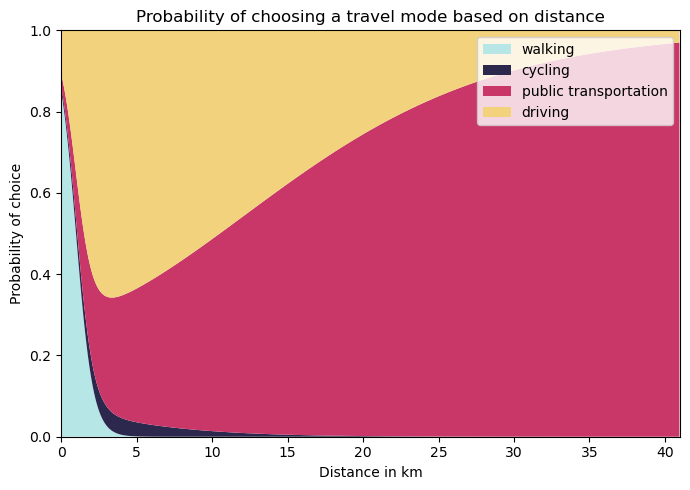

In [ ]:
import matplotlib.pyplot as plt



y0 = [y[i][0][0] for i in range(1000)]
y1 =  [ y[i][0][1] for i in range(1000)]
y2 = [ y[i][0][2] for i in range(1000)]
y3 = [ y[i][0][3] for i in range(1000)]

y_data = np.vstack([y0, y1, y2, y3])

# --- Concise outline ---
fig, ax = plt.subplots(figsize=(7, 5))

ax.stackplot(x, y_data,
             labels=['walking', 'cycling', 'public transportation', 'driving'],
             colors=['#b7e6e6', '#2c284d', '#c83768', '#f2d27d'])

ax.set(title="Probability of choosing a travel mode based on distance",
       xlabel="Distance in km",
       ylabel="Probability of choice",
       xlim=(0, 41),
       ylim=(0, 1))

ax.legend(loc='upper right')
plt.tight_layout()
plt.show()

In [33]:
for batch in london_dataset.iter_batch(batch_size=1):
    shared_features, items_features, available_items, choices = batch
    print("Shape of shared_features:", shared_features.shape)
    print("Shape of items_features:", items_features.shape)
    print("Shape of available_items:", available_items.shape)
    break

Shape of shared_features: (1, 19)
Shape of items_features: (1, 4, 8)
Shape of available_items: (1, 4)


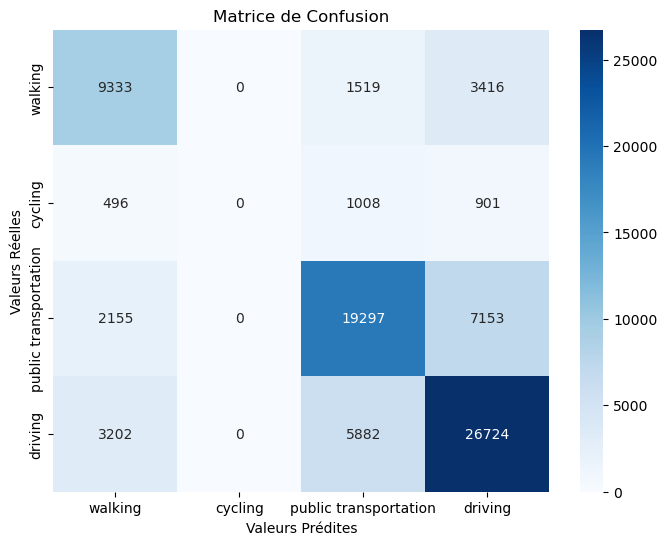

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
predicted_choices = np.argmax(london_model.predict_probas(london_dataset), axis=1)

cm = confusion_matrix(london_dataset.choices, predicted_choices)

plt.figure(figsize=(8, 6)) 

sns.heatmap(cm,
            annot=True,     
            fmt='d',      
            cmap='Blues',   
            xticklabels=["walking", "cycling", "public transportation", "driving"],
            yticklabels=["walking", "cycling", "public transportation", "driving"]) 

plt.title('Confusion Matrix') 
plt.ylabel('True Values')   
plt.xlabel('Predicted Values')   
plt.show() 